**Добро пожаловать на первое практическое задание в модулях, посвященных продвинутым экспериментам!**

В этом уроке мы посмотрели на то, как подбирать прокси-метрику, а сейчас попробуем сделать это самостоятельно и помочь команде классифайда подобрать еще одну.

Для выполнения задания вам нужно будет использовать код из лекции, а также вспомнить алгоритм и логику поиска прокси-метрик.

Практическое задание состоит из пяти задач. Общее количество баллов: 95.

По аналогии с задачей поиска прокси-метрики для продажи авто листером команде классифайда нужно найти прокси-метрику, хорошо коррелированную с покупкой авто искателем. Прокси-метрика нужна по тем же причинам, что и у листеров – чтобы точно знать долю искателей авто, которые закрыли через нас потребность.

Регулярно проводить такие опросы в команде не получится, но следить за эффективностью покупок авто через наш классифайд все равно нужно. Для этого команда классифайда провела обзвон наших искателей на предмет того, купили они в итоге авто с помощью классифайда или нет (поле: is_bought). Команда обзванивала пользователей, которые были активны в поиске объявлений, но ушли в отток (не было активности больше семи дней). При этом у пользователей не должно было быть активных объявлений за последние три месяца (для того, чтобы исключить листеров из обзвона).

Также команда достала определенные метрики, которые могут быть полезны для поиска прокси-метрики:

- `user_id` id пользователя;
- `views` суммарное количество просмотров объявлений за весь период активности в классифайде на момент ухода искателя в отток;
- `contacts` суммарное количество контактов по объявлениям (просмотры телефона и написанные сообщения) за весь период активности в классифайде на момент ухода в отток;
- `last_7_views` просмотры за 7 дней до ухода в отток;
- `last_3_views` просмотры за 3 дня до ухода в отток;
- `last_7_contacts` контакты за 7 дней до ухода в отток;
- `last_3_contacts` контакты за 3 дня до ухода в отток;
- `live_days` длительность в днях с первого момента появления в продукте до ухода в отток;
- `messages_events` количество написанных сообщений искателем;
- `add_to_favor_events` количество добавленных объявлений в избранное;
- `max_views_delta` разница между самым малоактивным в просмотрах днем (но не нулевым) и самым активным днем в просмотрах.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

In [2]:
df_finders = pd.read_csv("proxy_metrics_homework_3.csv")

In [3]:
df_finders.head()

,user_id,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,messages_events,max_views_delta,add_to_favor_events,is_bought
0,151042503,84,2,84,39,2,2,8,0,6,0.0,0
1,151212422,95,0,95,36,0,0,8,0,7,0.0,0
2,151206815,118,3,118,40,3,2,8,0,2,0.0,0
3,151284254,11,0,11,2,0,0,7,0,8,0.0,0
4,151088604,48,2,48,8,2,0,8,0,1,0.0,0


Напомним алгоритм для работы с прокси-метриками:

- найти хороших кандидатов на прокси-метрики;

(этот шаг ваши коллеги из классифайда уже сделали). От вас требуется проделать следующие шаги:
- провести корреляционный анализ;
- доработать первичный список;
- проверить мощность и уровень значимости теста;
- проверить на реальном А/Б-тесте, позволяет ли прокси-метрика детектить изменение целевой метрики. Анализ чувствительности прокси-метрики.

# Задание 1.

### Задание 1. EDA (1/6)
 
Начнем с описательного анализа данных (EDA). Он проводится для того, чтобы вы лучше погрузились в данные и уловили первые паттерны. Это поможет успешнее пройти следующие этапы.

Найдите среднюю конверсию в покупку авто для пользователей.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [7]:
print(df_finders.shape[0], df_finders.user_id.nunique())

1193 1193


In [9]:
round(float(df_finders.is_bought.sum() / df_finders.shape[0]), 2)

0.34

### Задание 1. EDA (2/6)
 
Какое среднее количество контактов за весь период у тех, кто не купил авто в итоге?

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [31]:
buyer_cohort = df_finders[df_finders["is_bought"] == 1]
not_buyer_cohort = df_finders[df_finders["is_bought"] == 0]

In [32]:
round(float(not_buyer_cohort["contacts"].mean()), 2)

12.98

### Задание 1. EDA (3/6)

Посчитайте, во сколько раз среднее количество добавлений в избранное (`add_to_favor_events`) отличается для каждой из двух когорт (тех, кто купил авто и тех, кто не купил авто).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [33]:
print(
    round(
        float(buyer_cohort["add_to_favor_events"].mean())
        / float(not_buyer_cohort["add_to_favor_events"].mean()),
        2,
    ),
)

2.03


### Задание 1. EDA (4/6)
 
Найдите долю пользователей, кто не совершил ни одного контакта для каждой из двух когорт (тех, кто купил авто и тех, кто не купил авто).

В ответе укажите долю среди тех, кто купил авто.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.



In [36]:
round(
    float(
        buyer_cohort[buyer_cohort["contacts"] == 0
        ].shape[0]
        / buyer_cohort.shape[0]
    ),
    2,
)

0.04

### Задание 1. EDA (5/6)

Найдите средний LT (`lifetime` — длительность от первого дня до ухода в отток) для двух когорт. Как вы думаете, с чем может быть связано различие в длительности?

В ответе укажите LT пользователей, которые купили авто.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.



In [26]:
df_finders.head()

,user_id,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,messages_events,max_views_delta,add_to_favor_events,is_bought
0,151042503,84,2,84,39,2,2,8,0,6,0.0,0
1,151212422,95,0,95,36,0,0,8,0,7,0.0,0
2,151206815,118,3,118,40,3,2,8,0,2,0.0,0
3,151284254,11,0,11,2,0,0,7,0,8,0.0,0
4,151088604,48,2,48,8,2,0,8,0,1,0.0,0


In [37]:
print(f"""
    средний LT для когорты купивших автомобиль: {
    round(
        float(buyer_cohort["live_days"].mean()),
        2,
    )
}
    средний LT для когорты не купивших автомобиль: {
    round(
        float(not_buyer_cohort["live_days"].mean()),
        2,
    )
}
""")


    средний LT для когорты купивших автомобиль: 10.22
    средний LT для когорты не купивших автомобиль: 12.72



### Задание 1. EDA (6/6)

Найдите отношение между просмотрами и контактами для двух когорт. Как вы думаете, почему есть такие различия в этом параметре?

В ответе укажите отношение контактов к просмотрам в когорте купивших авто.

Обратите внимание, что по умолчанию лучше проводить анализ на том же уровне, что и основные метрики, которые вы будете рассчитывать. В нашем случае нужно посчитать ответ на уровне пользователя с последующим выводом среднего. 

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [47]:
print(f'''
    отношение контактов к просмотрам в когорте купивших авто: {round(float((buyer_cohort['contacts'] / buyer_cohort['views']).mean()), 2)}
    отношение контактов к просмотрам в когорте не купивших авто: {round(float((not_buyer_cohort['contacts'] / not_buyer_cohort['views']).mean()), 2)}
''')


    отношение контактов к просмотрам в когорте купивших авто: 0.03
    отношение контактов к просмотрам в когорте не купивших авто: 0.02



# Задание 2.

### Задание 2. Поиск корреляции (1/2)
 
Пройдитесь по всем метрикам из исходных данных и найдите TOP-3 метрики, которые дают наилучшую корреляцию с фактом покупки авто.

In [ ]:
def find_cat_quant_correlation(quant_value, binary_mask, plot=True, print_inference=True):
    '''
    quant_value - количественная переменная,  для которой считаем корреляцию
    binary_mask - бинарная переменная (True, False), для которой считаем корреляцию
    plot - надо ли отрисовывать график
    print_inference - надо ли принтовать выводы и основные метркии
    '''

    # разбиваем количественную метрику на группы по тому, была ли целевая конверсия или нет
    group_1 = quant_value[binary_mask] # binary = 1
    group_2 = quant_value[~binary_mask] # binary = 0

    # считаем pointbiserial корреляцию, тест Краскелла-Уолесса и обычный Т-тест
    pointbiserialr = ss.pointbiserialr(quant_value, binary_mask)[0]
    kruskal_pval = ss.kruskal(group_1, group_2)[1]
    ttest_pval = ss.ttest_ind(group_1, group_2)[1]

    # принтуем выводы
    if print_inference:
        print('Mean quant value for group (binary=1) =', group_1.mean())
        print('Mean quant value for group (binary=0) =', group_2.mean())

        print('Median quant value for group (binary=1) =', group_1.median())
        print('Median quant value for group (binary=0) =', group_2.median())

        print('Kruskal-Wallis H Test p-value =', kruskal_pval)
        print('T-test p-value =', ttest_pval)
        print('point biserial correlation =', pointbiserialr)

    # рисуем график распределения для двух групп, чтобы проиллюстрировать различия в группах
    if plot:
        plt.figure(figsize=(16,6))
        sns.kdeplot(group_1, color = 'red', label = 'Binary = True')
        sns.kdeplot(group_2, color = 'blue', label = 'Binary = False')
        plt.axvline(x = group_1.mean(), linestyle = '--', color = 'red')
        plt.axvline(x = group_2.mean(), linestyle = '--', color = 'blue')
        plt.legend()

    return({'point biserial R':pointbiserialr,
            'kruskal_pval':kruskal_pval,
            'ttest_pval':ttest_pval})

In [66]:
dct = {}

for col in df_finders.columns[1:-1]:
    corr_value = find_cat_quant_correlation(quant_value=df_finders[col], binary_mask=df_finders['is_bought']==1, plot=False, print_inference=False)
    dct[col] = corr_value['point biserial R']
    print(f"For column {col} corr is {corr_value['point biserial R']}")
    

For column views corr is 0.1096371590745879
For column contacts corr is 0.19871891825759602
For column last_7_views corr is 0.2081632938478567
For column last_3_views corr is 0.3112803930747102
For column last_7_contacts corr is 0.28483383958689656
For column last_3_contacts corr is 0.3632619266023356
For column live_days corr is -0.12488555151409067
For column messages_events corr is 0.08631764000149167
For column max_views_delta corr is 0.16061005260924757
For column add_to_favor_events corr is 0.06367349881474366


In [76]:
top_columns = dict(sorted(dct.items(), key=lambda item: abs(item[1]), reverse=True))

for key, value in list(top_columns.items())[:3]:
    print(f"{key}: {value}")

last_3_contacts: 0.3632619266023356
last_3_views: 0.3112803930747102
last_7_contacts: 0.28483383958689656


### Задание 2. Поиск корреляции (2/2)
 
Найдите и введите значение `point biserial correlation` между метриками `is_bought` и `add_to_favor_events`.

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [78]:
round(float(top_columns['add_to_favor_events']), 2)

0.06

# Задание 3.

### Задание 3. Новые метрики (1/5) 

Исходя из найденных корреляций, попробуйте предложить новые метрики, которые дадут бОльшую корреляцию. И посчитать, какое новое значение корреляции удалось достичь.

Попробуем логарифмирование основных метрик. Не забываем добавлять единицу, чтобы избавиться от нулей в данных.

Рассчитайте коэффициент `point biserial correlation` для логарифма метрики (`last_3_contacts` + 1).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

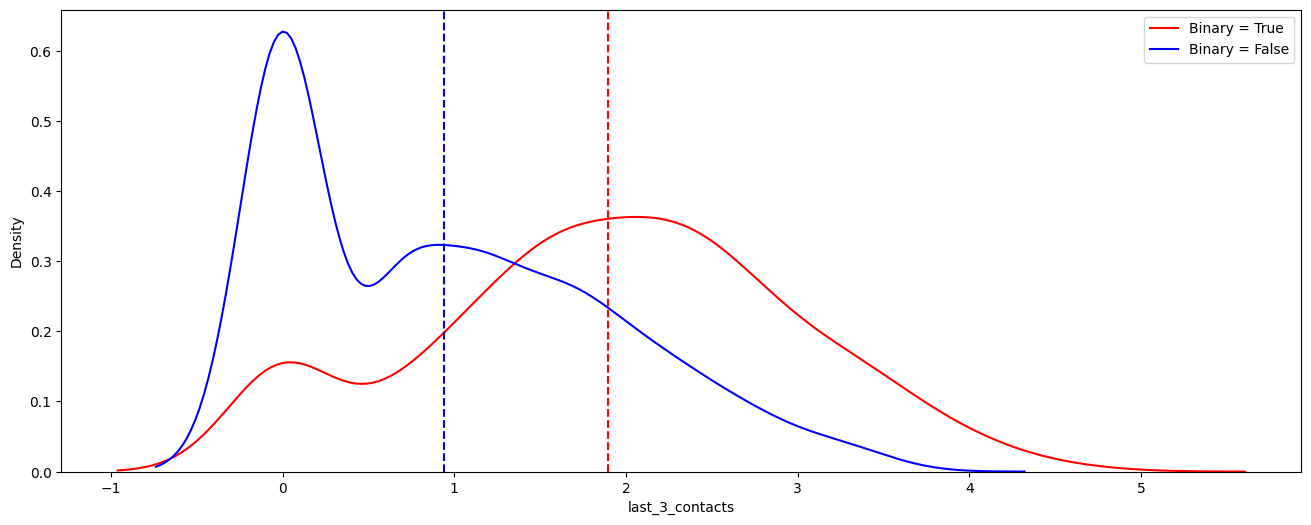

In [80]:
corr_last3_cont = find_cat_quant_correlation(quant_value=np.log(df_finders['last_3_contacts']+1), binary_mask=df_finders['is_bought']==1, plot=True, print_inference=False)

In [81]:
round(float(corr_last3_cont['point biserial R']), 2)

0.42

### Задание 3. Новые метрики (2/5)

Рассчитайте коэффициент `point biserial correlation` для логарифма метрики (`last_3_views` + 1).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

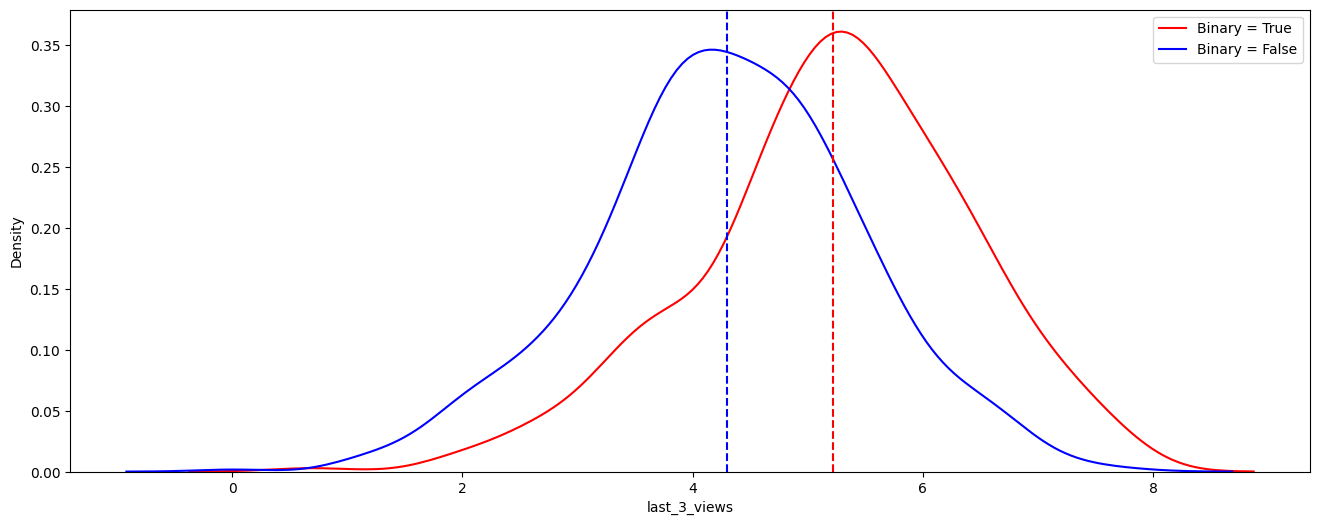

In [83]:
corr_last3_views = find_cat_quant_correlation(quant_value=np.log(df_finders['last_3_views']+1), binary_mask=df_finders['is_bought']==1, plot=True, print_inference=False)

In [84]:
round(float(corr_last3_views['point biserial R']), 2)

0.35

### Задание 3. Новые метрики (3/5)
 
Рассчитайте коэффициент `point biserial correlation` для логарифма метрики (`add_to_favor_events` + 1).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

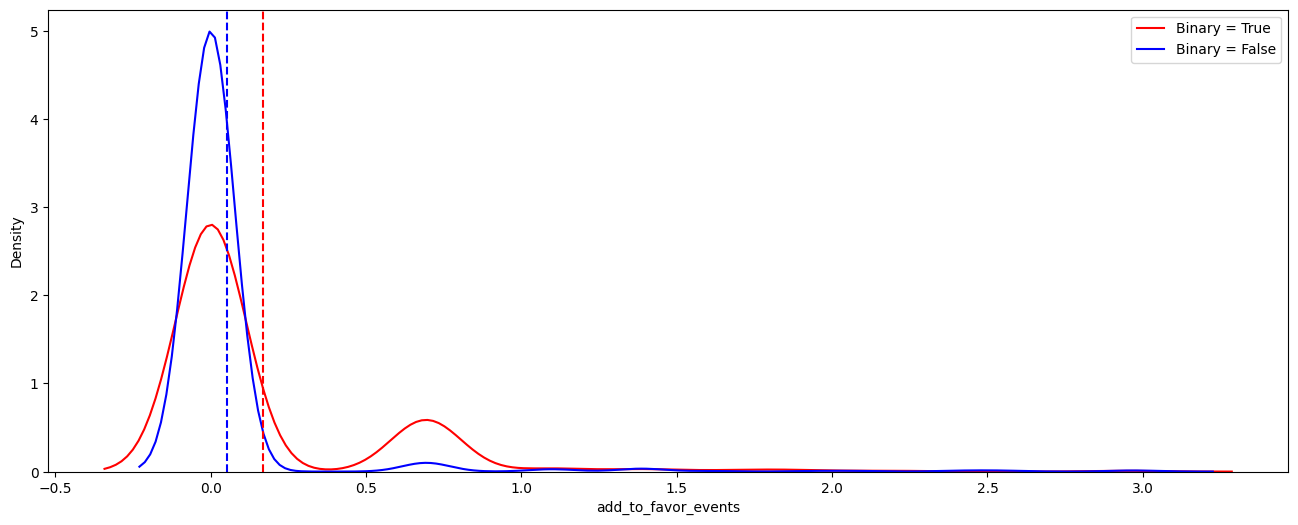

In [85]:
corr_add2fav = find_cat_quant_correlation(quant_value=np.log(df_finders['add_to_favor_events']+1), binary_mask=df_finders['is_bought']==1, plot=True, print_inference=False)

In [86]:
round(float(corr_add2fav['point biserial R']), 2)

0.17

### Задание 3. Новые метрики (4/5)

Попробуем найти соотношение основных метрик.

Рассчитайте коэффициент `point biserial correlation` для метрики (`last_3_contacts` / (`last_3_views` +1)).

Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

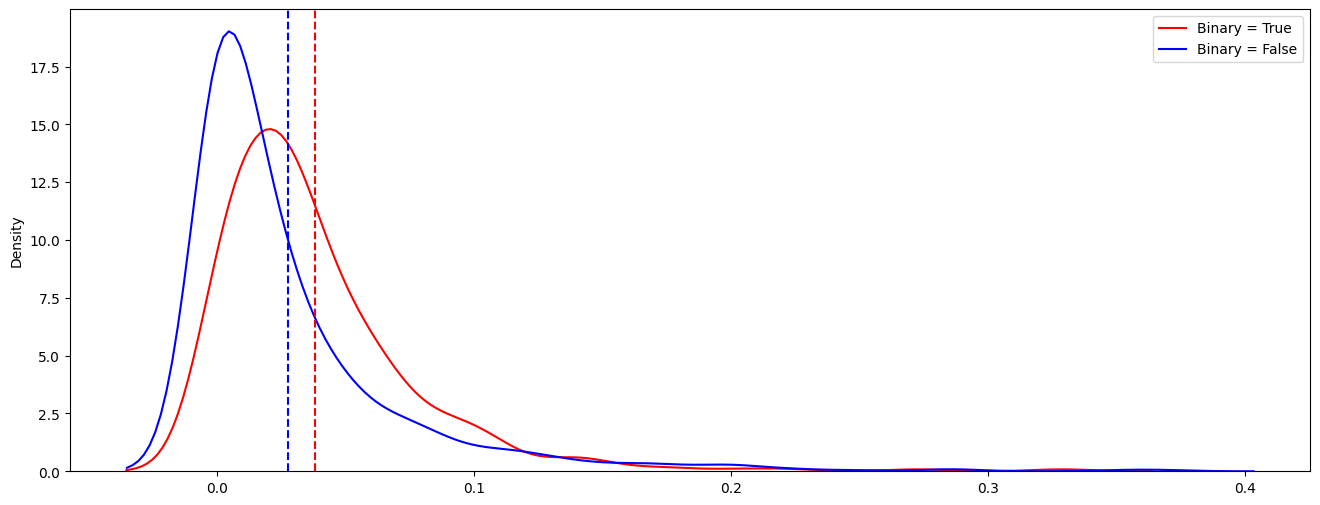

In [88]:
corr_relation = find_cat_quant_correlation(quant_value=df_finders['last_3_contacts'] / (df_finders['last_3_views']+1), binary_mask=df_finders['is_bought']==1, plot=True, print_inference=False)

In [89]:
round(float(corr_relation['point biserial R']), 2)

0.11

### Задание 3. Новые метрики (5/5)

Какие из метрик мы возьмем далее в работу?

Ответ:
- last_3_contacts
- last_3_views

# Задание 4.

### Задание 4. Порог для прокси-метрики (1/2)

Найдите порог для прокси-метрики `last_3_contacts`.

Введите ответ в поле ниже с точностью до ОДНОГО знака после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [90]:
def proxy_metrics_bins_analizer(quant_value, binary_mask, step):

    #разбиваем исходную количественную величину на квантили с нужным шагом
    deciles_bins = np.quantile(quant_value, np.arange(0, 1, step))
    #разбиваем ряд на бины
    inds = np.digitize(quant_value, deciles_bins, right = False)
    # агрегируем
    df = pd.DataFrame({'quant_value':quant_value,
                  'binary': binary_mask,
                  'bins': inds})
    inference = df.groupby('bins').mean()

    #считаем point biserial корреляцию
    point_biserial_R = find_cat_quant_correlation(quant_value = quant_value, binary_mask=binary_mask, plot = False, print_inference = False)['point biserial R']

    # рисуем график
    plt.figure(figsize=(12,6))
    sns.lineplot(y = inference['quant_value'], x = inference.index*step, color = 'red', label = 'quant_value')
    plt.axhline(y = quant_value.median(), linestyle = '--', color = 'red')
    plt.text(x = inds.mean()*step, y = np.quantile(quant_value, 0.95), s ='point_biserial_R = {}'.format(point_biserial_R), )
    ax2 = plt.twinx()
    sns.lineplot(y = inference['binary'], x = inference.index*step, color = 'blue', ax=ax2, label = 'binary share')
    plt.axhline(y = binary_mask.mean(), linestyle = '--', color = 'blue')
    plt.legend()

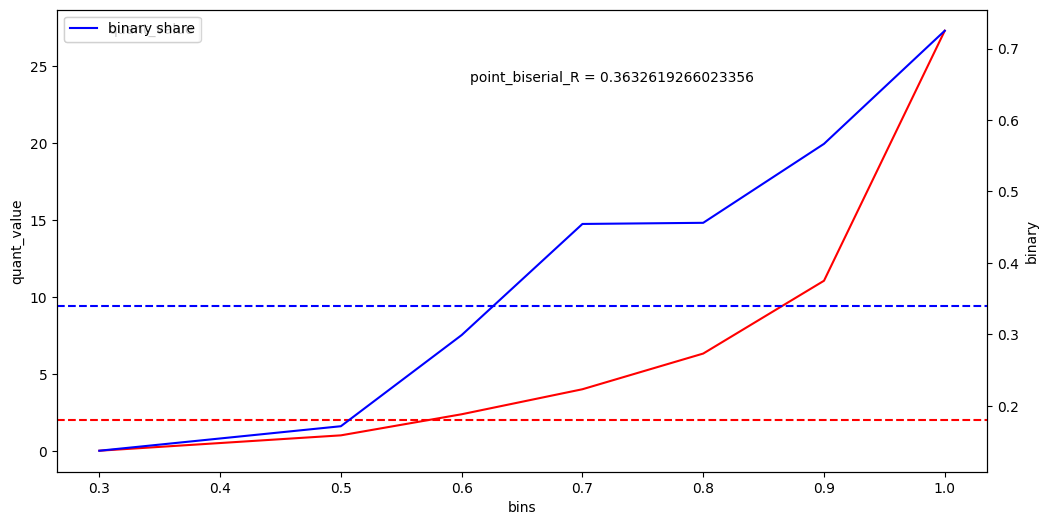

In [94]:
proxy_metrics_bins_analizer(quant_value=df_finders['last_3_contacts'], binary_mask=df_finders['is_bought']==1, step=0.1)

In [95]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return (cramers_v)

In [97]:
def max_cramerv_corr_finder(quant_value, binary_mask, plot=True, print_inference=True, step=1):
    '''
    quant_value - исходная количественная переменная по которой мы пытаемся найти порог
    binary_mask - бинарная метрика с целевой конверсией к которой мы исщем максимальную корреляцию
    plot - нужно ли рисовать граиф
    print_inference - нужно ли принтовать выводы
    step - размер шага с которым мы идем по quant_value и определяем пороги
    '''
    # определяем вектор исходной количественной переменной, на котором мы будет искать максимальную корреляцию
    arange = np.arange(min(quant_value), max(quant_value), step)
    cramers_v_list = []

    #циклом проходим по всем порогам и находим значение cramers_v
    for i in arange:
        confusion_matrix = pd.crosstab(binary_mask, quant_value>i)
        cramers_v_i = cramers_v(confusion_matrix.values)
        cramers_v_list.append(cramers_v_i)

    # сохраняем максимальные найденные значения корреляции и порога при котором она достигается
    max_corr_quant_value = arange[np.argmax(np.array(cramers_v_list))]
    max_cramer_v = max(cramers_v_list)

    # отрисовываем график
    if plot:
        sns.lineplot(x = arange, y = cramers_v_list)
        plt.axhline(y = np.array(cramers_v_list).max(), linestyle = '--', color = 'red')
        plt.axvline(x = max_corr_quant_value, linestyle = '--', color = 'red')
        plt.xlabel('quant values')
        plt.ylabel('Cramer-V')

    ## принтуем выводы
    if print_inference:
        print('Maximum Cramer V =', np.array(cramers_v_list).max())
        print('Maximum Cramer V quant value = ', max_corr_quant_value)

    return({'max_cramer_v': max_cramer_v,
           'max_corr_quant_value': max_corr_quant_value})

Maximum Cramer V = 0.3672697346990414
Maximum Cramer V quant value =  3.0


{'max_cramer_v': np.float64(0.3672697346990414),
 'max_corr_quant_value': np.float64(3.0)}

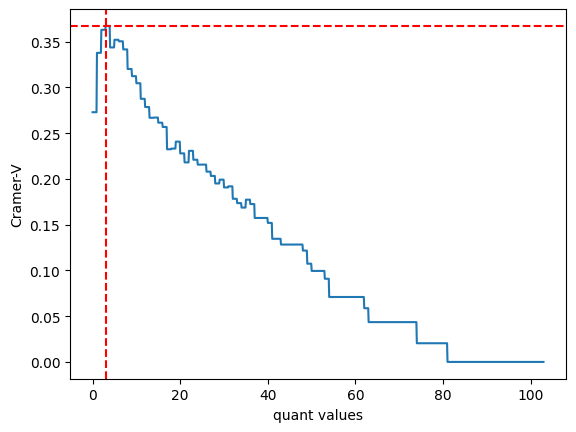

In [ ]:
max_cramerv_corr_finder(quant_value=df_finders['last_3_contacts'], binary_mask=df_finders['is_bought']==1, step=1)

### Задание 4. Порог для прокси-метрики (2/2)

Найдите порог для прокси-метрики `last_3_views`.

Введите ответ в поле ниже с точностью до ОДНОГО знака после запятой. Используйте точку в качестве разделителя целой и дробной части.



Maximum Cramer V = 0.3486475362928702
Maximum Cramer V quant value =  151


{'max_cramer_v': np.float64(0.3486475362928702),
 'max_corr_quant_value': np.int64(151)}

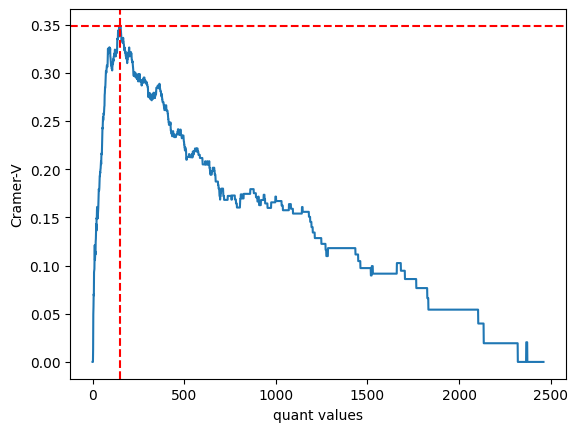

In [100]:
max_cramerv_corr_finder(quant_value=df_finders['last_3_views'], binary_mask=df_finders['is_bought']==1, step=1)